In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.append(str(project_root))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr
wr.filterwarnings('ignore')

In [3]:
sns.set_theme(
    style="darkgrid",   # soft gray background
    context="notebook"  # good sizing for EDA
)

In [4]:
df = pd.read_csv('../data/cs-training.csv')
df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
df = df.drop(columns = ['Unnamed: 0'])

In [7]:
delinq_cols = [
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate'
]

df[delinq_cols] = df[delinq_cols].replace({96: np.nan, 98: np.nan})

In [8]:
X = df.drop(columns=['SeriousDlqin2yrs'])
y = df['SeriousDlqin2yrs']

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [11]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'median')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

In [ ]:
'''
log_cols = ['MonthlyIncome', 'DebtRatio', 'RevolvingUtilizationOfUnsecuredLines']

X_train_df = pd.DataFrame(X_train_imp, columns = X.columns)
X_test_df  = pd.DataFrame(X_test_imp, columns=X.columns)


for col in log_cols:
    X_train_df[col] = np.log1p(X_train_df[col])
    X_test_df[col]  = np.log1p(X_test_df[col])
'''

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

In [13]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter = 1000,
    class_weight = 'balanced',
    solver = 'lbfgs'
)

model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [15]:
from sklearn.metrics import roc_auc_score

preds_proba = model.predict_proba(X_test_scaled)[:, 1]
roc_auc_score(y_test, preds_proba)

np.float64(0.8204618120710012)

In [17]:
from sklearn.metrics import confusion_matrix

y_preds = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_preds)
cm

array([[24397,  3598],
       [  752,  1253]])

Text(0.5, 1.0, 'Baseline Logistic Regression Confusion Matrix (0.5)')

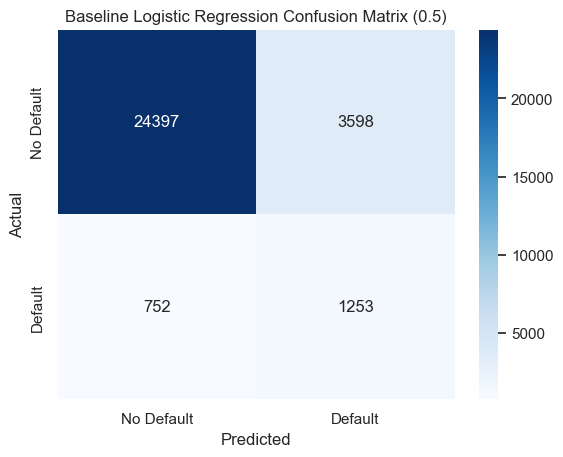

In [19]:
sns.heatmap(
    cm,
    annot = True,
    fmt = 'd',
    cmap = 'Blues',
    xticklabels = ['No Default', 'Default'],
    yticklabels = ['No Default', 'Default']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Logistic Regression Confusion Matrix (0.5)')

In [20]:
log_cols = ['MonthlyIncome', 'DebtRatio', 'RevolvingUtilizationOfUnsecuredLines']

X_train_df = pd.DataFrame(X_train_imp, columns = X.columns)
X_test_df = pd.DataFrame(X_test_imp, columns = X.columns)
for col in log_cols:
    X_train_df[col] = np.log1p(X_train_df[col])
    X_test_df[col] = np.log1p(X_test_df[col])

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

In [22]:
model = LogisticRegression(
    max_iter = 1000,
    class_weight = 'balanced',
    solver = 'lbfgs'
)

model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [23]:
preds_proba = model.predict_proba(X_test_scaled)[:,1]
roc_auc_score(y_test, preds_proba)

np.float64(0.8578640735186501)

Text(0.5, 1.0, 'Baseline Logistic Regression Confusion Matrix (Log Transformed) (0.5)')

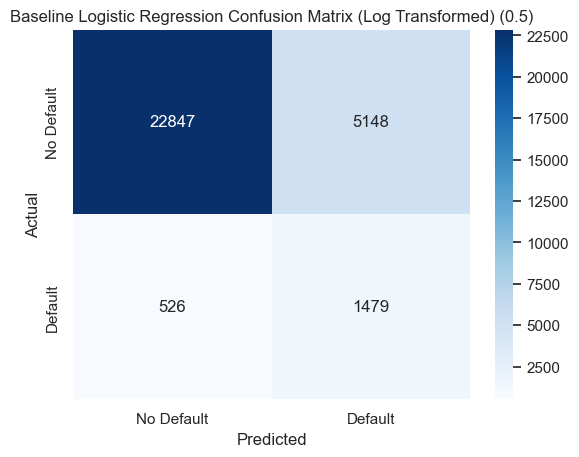

In [25]:
y_preds = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_preds)
cm

sns.heatmap(
    cm,
    annot = True,
    fmt = 'd',
    cmap = 'Blues',
    xticklabels = ['No Default', 'Default'],
    yticklabels = ['No Default', 'Default']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Logistic Regression Confusion Matrix (Log Transformed) (0.5)')

In [28]:
from sklearn.metrics import precision_score, recall_score

precision = round(precision_score(y_test, y_preds), 2)
recall = round(recall_score(y_test, y_preds), 2)

print(f'Precision: {precision} \n Recall: {recall}')

Precision: 0.22 
 Recall: 0.74


In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89     27995
           1       0.22      0.74      0.34      2005

    accuracy                           0.81     30000
   macro avg       0.60      0.78      0.62     30000
weighted avg       0.93      0.81      0.85     30000



In [34]:
from sklearn.metrics import precision_recall_curve

y_probs = model.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

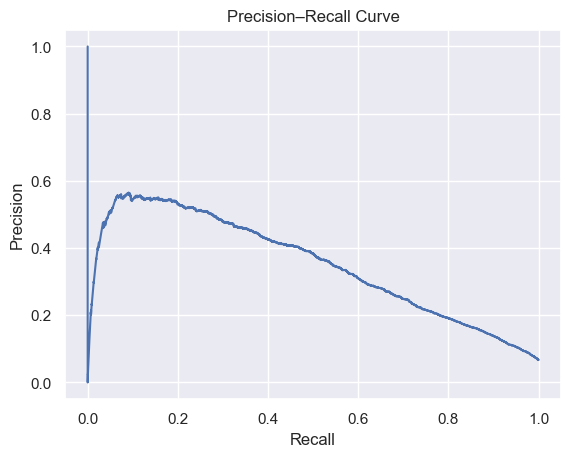

In [35]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.show()

In [36]:
from sklearn.metrics import average_precision_score

y_probs = model.predict_proba(X_test_scaled)[:,1]

ap = average_precision_score(y_test, y_probs)
print("PR AUC (Average Precision):", ap)

PR AUC (Average Precision): 0.34886727378609017


ROC AUC:  0.8355256527372407


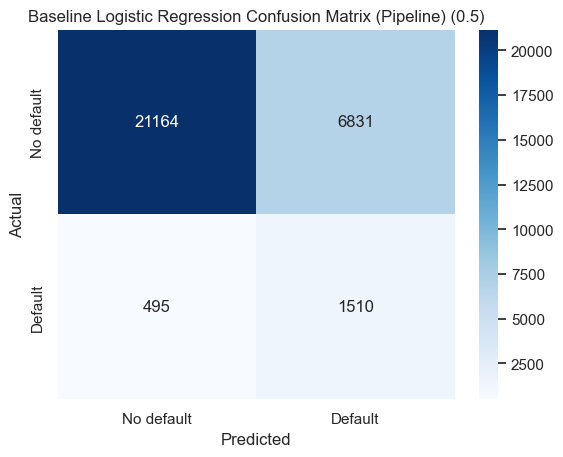

In [37]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../data/cs-training.csv')
df = df.drop(columns = ['Unnamed: 0'])

X = df.drop(columns=['SeriousDlqin2yrs'])
y = df['SeriousDlqin2yrs']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

log_cols = ['MonthlyIncome', 'DebtRatio', 'RevolvingUtilizationOfUnsecuredLines']
other_cols = [c for c in X_train.columns if c not in log_cols]

# log col transformation + imputation
log_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy = "median")),
    ("log1p", FunctionTransformer(np.log1p, feature_names_out = "one-to-one")),
])

# other col imputation
other_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy = "median")),
])

# concatenate result of both log col + other col pipes side by side
# drop columns not used in either
preprocess = ColumnTransformer(
    transformers = [
        ("log", log_pipe, log_cols),
        ("other", other_pipe, other_cols),
    ],
    remainder = "drop"
)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter = 1000,
        class_weight = "balanced",
        solver = "lbfgs"
    ))
])

pipe.fit(X_train, y_train)

preds_proba = pipe.predict_proba(X_test)[:,1]
print("ROC AUC: ", roc_auc_score(y_test, preds_proba))

y_preds = pipe.predict(X_test)
cm = confusion_matrix(y_test, y_preds)

sns.heatmap(
    cm,
    annot = True,
    fmt = 'd',
    cmap = 'Blues',
    xticklabels = ['No default', 'Default'],
    yticklabels = ['No default', 'Default'],
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Logistic Regression Confusion Matrix (Pipeline) (0.5)')
plt.show()


In [39]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

param_grid = {'model__C': [0.01, .1, 1, 3, 10, 30, 100]}
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

grid = GridSearchCV(pipe, param_grid, scoring="average_precision", cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV PR AUC:", grid.best_score_)
best_pipe = grid.best_estimator_

Best params: {'model__C': 30}
Best CV PR AUC: 0.30532208018606594


In [40]:
best_pipe = grid.best_estimator_
probs = best_pipe.predict_proba(X_test)[:, 1]

print("Test ROC AUC:", roc_auc_score(y_test, probs))
print("Test PR AUC:", average_precision_score(y_test, probs))

Test ROC AUC: 0.8355354870548223
Test PR AUC: 0.3169106473893493


In [42]:
import joblib
from pathlib import Path

Path("artifacts").mkdir(exist_ok=True)

joblib.dump(best_pipe, "artifacts/lr_pipeline_best.joblib")

['artifacts/lr_pipeline_best.joblib']

In [41]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

for pct in [0.01, 0.02, 0.05, 0.10]:
    threshold = np.quantile(probs, 1 - pct)
    preds = (probs >= threshold).astype(int)

    print(
        f"Top {int(pct*100)}% flagged | "
        f"Precision: {precision_score(y_test, preds):.3f} | "
        f"Recall: {recall_score(y_test, preds):.3f}"
    )


Top 1% flagged | Precision: 0.490 | Recall: 0.073
Top 2% flagged | Precision: 0.520 | Recall: 0.156
Top 5% flagged | Precision: 0.435 | Recall: 0.325
Top 10% flagged | Precision: 0.323 | Recall: 0.484


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def save_confusion_matrix(y_true, y_pred, path, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["No Default", "Default"],
        yticklabels=["No Default", "Default"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(path, dpi=200)
    plt.close()

In [45]:
def preds_top_k(probs, k_pct):
    # k_pct = 0.02 means top 2%
    thr = np.quantile(probs, 1 - k_pct)
    return (probs >= thr).astype(int), thr

y_pred_top2, thr2 = preds_top_k(probs, 0.02)
save_confusion_matrix(
    y_test, y_pred_top2,
    "artifacts/cm_lr_top2pct.png",
    title=f"LR Confusion Matrix (Top 2% flagged | thr={thr2:.3f})"
)

y_pred_top5, thr5 = preds_top_k(probs, 0.05)
save_confusion_matrix(
    y_test, y_pred_top5,
    "artifacts/cm_lr_top5pct.png",
    title=f"LR Confusion Matrix (Top 5% flagged | thr={thr5:.3f})"
)


In [46]:
print("Flagged (top 2%):", y_pred_top2.mean())
print("Flagged (top 5%):", y_pred_top5.mean())
print("Thresholds:", thr2, thr5)


Flagged (top 2%): 0.02
Flagged (top 5%): 0.05
Thresholds: 0.8670837104876178 0.7759548823508966


In [47]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

def save_pr_curve(y_true, probs, path, title="Precision-Recall Curve"):
    p, r, _ = precision_recall_curve(y_true, probs)
    plt.figure(figsize=(5,4))
    plt.plot(r, p)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(path, dpi=200)
    plt.close()

def save_roc_curve(y_true, probs, path, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, probs)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title} (AUC={auc(fpr,tpr):.3f})")
    plt.tight_layout()
    plt.savefig(path, dpi=200)
    plt.close()

save_pr_curve(y_test, probs, "artifacts/pr_curve_lr.png", "LR PR Curve")
save_roc_curve(y_test, probs, "artifacts/roc_curve_lr.png", "LR ROC Curve")


In [48]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score

def topk_table(y_true, probs, pcts=(0.01, 0.02, 0.05, 0.10)):
    rows = []
    for pct in pcts:
        thr = np.quantile(probs, 1 - pct)
        pred = (probs >= thr).astype(int)
        rows.append({
            "top_pct_flagged": pct,
            "threshold": thr,
            "precision": precision_score(y_true, pred),
            "recall": recall_score(y_true, pred),
        })
    return pd.DataFrame(rows)

tbl = topk_table(y_test, probs)
tbl.to_csv("artifacts/topk_thresholds_lr.csv", index=False)
tbl


,top_pct_flagged,threshold,precision,recall
0,0.01,0.923553,0.490000,0.073317
1,0.02,0.867084,0.520000,0.155611
2,0.05,0.775955,0.434667,0.325187
3,0.10,0.702956,0.323333,0.483791
